<p style="text-align: center;"><img src="https://lms.techproeducation.com/pluginfile.php/1/theme_edumy/headerlogo2/1663129929/logo.png" class="img-fluid" alt="CLRSWY"></p>

# WELCOME!

In this project, you must apply EDA processes for the development of predictive models. Handling outliers, domain knowledge and feature engineering will be challenges.

Also, this project aims to improve your ability to implement algorithms for Multi-Class Classification. Thus, you will have the opportunity to implement many algorithms commonly used for Multi-Class Classification problems.

Before diving into the project, please take a look at the determines and tasks.

# Determines

The 2012 US Army Anthropometric Survey (ANSUR II) was executed by the Natick Soldier Research, Development and Engineering Center (NSRDEC) from October 2010 to April 2012 and is comprised of personnel representing the total US Army force to include the US Army Active Duty, Reserves, and National Guard. In addition to the anthropometric and demographic data described below, the ANSUR II database also consists of 3D whole body, foot, and head scans of Soldier participants. These 3D data are not publicly available out of respect for the privacy of ANSUR II participants. The data from this survey are used for a wide range of equipment design, sizing, and tariffing applications within the military and has many potential commercial, industrial, and academic applications.

The ANSUR II working databases contain 93 anthropometric measurements which were directly measured, and 15 demographic/administrative variables explained below. The ANSUR II Male working database contains a total sample of 4,082 subjects. The ANSUR II Female working database contains a total sample of 1,986 subjects.


DATA DICT:
https://data.world/datamil/ansur-ii-data-dictionary/workspace/file?filename=ANSUR+II+Databases+Overview.pdf

---

To achieve high prediction success, you must understand the data well and develop different approaches that can affect the dependent variable.

Firstly, try to understand the dataset column by column using pandas module. Do research within the scope of domain (body scales, and race characteristics) knowledge on the internet to get to know the data set in the fastest way. 

You will implement ***Logistic Regression, Support Vector Machine, XGBoost, Random Forest*** algorithms. Also, evaluate the success of your models with appropriate performance metrics.

At the end of the project, choose the most successful model and try to enhance the scores with ***SMOTE*** make it ready to deploy. Furthermore, use ***SHAP*** to explain how the best model you choose works.

# Tasks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import cufflinks as cf

from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()


%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss, recall_score, accuracy_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, roc_auc_score, auc #RocCurveDisplay
#svc_disp = RocCurveDisplay.from_estimator(svc, X_test, y_test)
#rfc_disp = RocCurveDisplay.from_estimator(rfc, X_test, y_test, ax=svc_disp.ax_)
from sklearn.metrics import roc_curve, average_precision_score, precision_recall_curve
from sklearn.preprocessing import  LabelEncoder


import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

In [2]:
df1 = pd.read_csv("ANSUR II MALE Public.csv", encoding='latin-1') 

In [3]:
df2=pd.read_csv("ANSUR II FEMALE Public.csv", encoding='latin-1') 

In [4]:
df2=df2.rename(columns={"SubjectId": "subjectid"})

In [5]:
df1.shape

(4082, 108)

In [6]:
df2.shape

(1986, 108)

In [7]:
df3 = df1.append([df2])

In [8]:
df3.shape

(6068, 108)

In [9]:
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    return str

summary(df3)

Data shape: (6068, 108)
___________________________
Data Types:
int64     99
object     9
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
Age,int64,6068,42,0,17,58
Branch,object,6068,3,0,Combat Arms,Combat Support
Component,object,6068,3,0,Army National Guard,Regular Army
DODRace,int64,6068,7,0,1,8
Date,object,6068,253,0,1-Aug-11,9-Nov-11
...,...,...,...,...,...,...
waistfrontlengthsitting,int64,6068,188,0,289,494
waistheightomphalion,int64,6068,350,0,805,1245
weightkg,int64,6068,783,0,358,1442
wristcircumference,int64,6068,79,0,124,216


In [10]:
def duplicate_values(df):
    print("Duplicate check...")
    num_duplicates = df.duplicated(subset=None, keep='first').sum()
    if num_duplicates > 0:
        print("There are", num_duplicates, "duplicated observations in the dataset.")
        df.drop_duplicates(keep='first', inplace=True)
        print(num_duplicates, "duplicates were dropped!")
        print('*' * 100)
    else:
        print("There are no duplicated observations in the dataset.")

In [11]:
duplicate_values(df3)

Duplicate check...
There are no duplicated observations in the dataset.


In [12]:
def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending = False)
    missing_percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending = False)
    missing_values = pd.concat([missing_number, missing_percent], axis = 1, keys = ['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number'] > 0]

In [13]:
missing_values(df3)

,Missing_Number,Missing_Percent
Ethnicity,4647,0.765821


In [14]:
df3.isnull().sum()

subjectid                         0
abdominalextensiondepthsitting    0
acromialheight                    0
acromionradialelength             0
anklecircumference                0
                                 ..
DODRace                           0
Age                               0
Heightin                          0
Weightlbs                         0
WritingPreference                 0
Length: 108, dtype: int64

In [15]:
df3.loc[:, df3.isnull().any()]

,Ethnicity
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
1981,Mexican
1982,Mexican
1983,NaN
1984,Mexican


<AxesSubplot: >

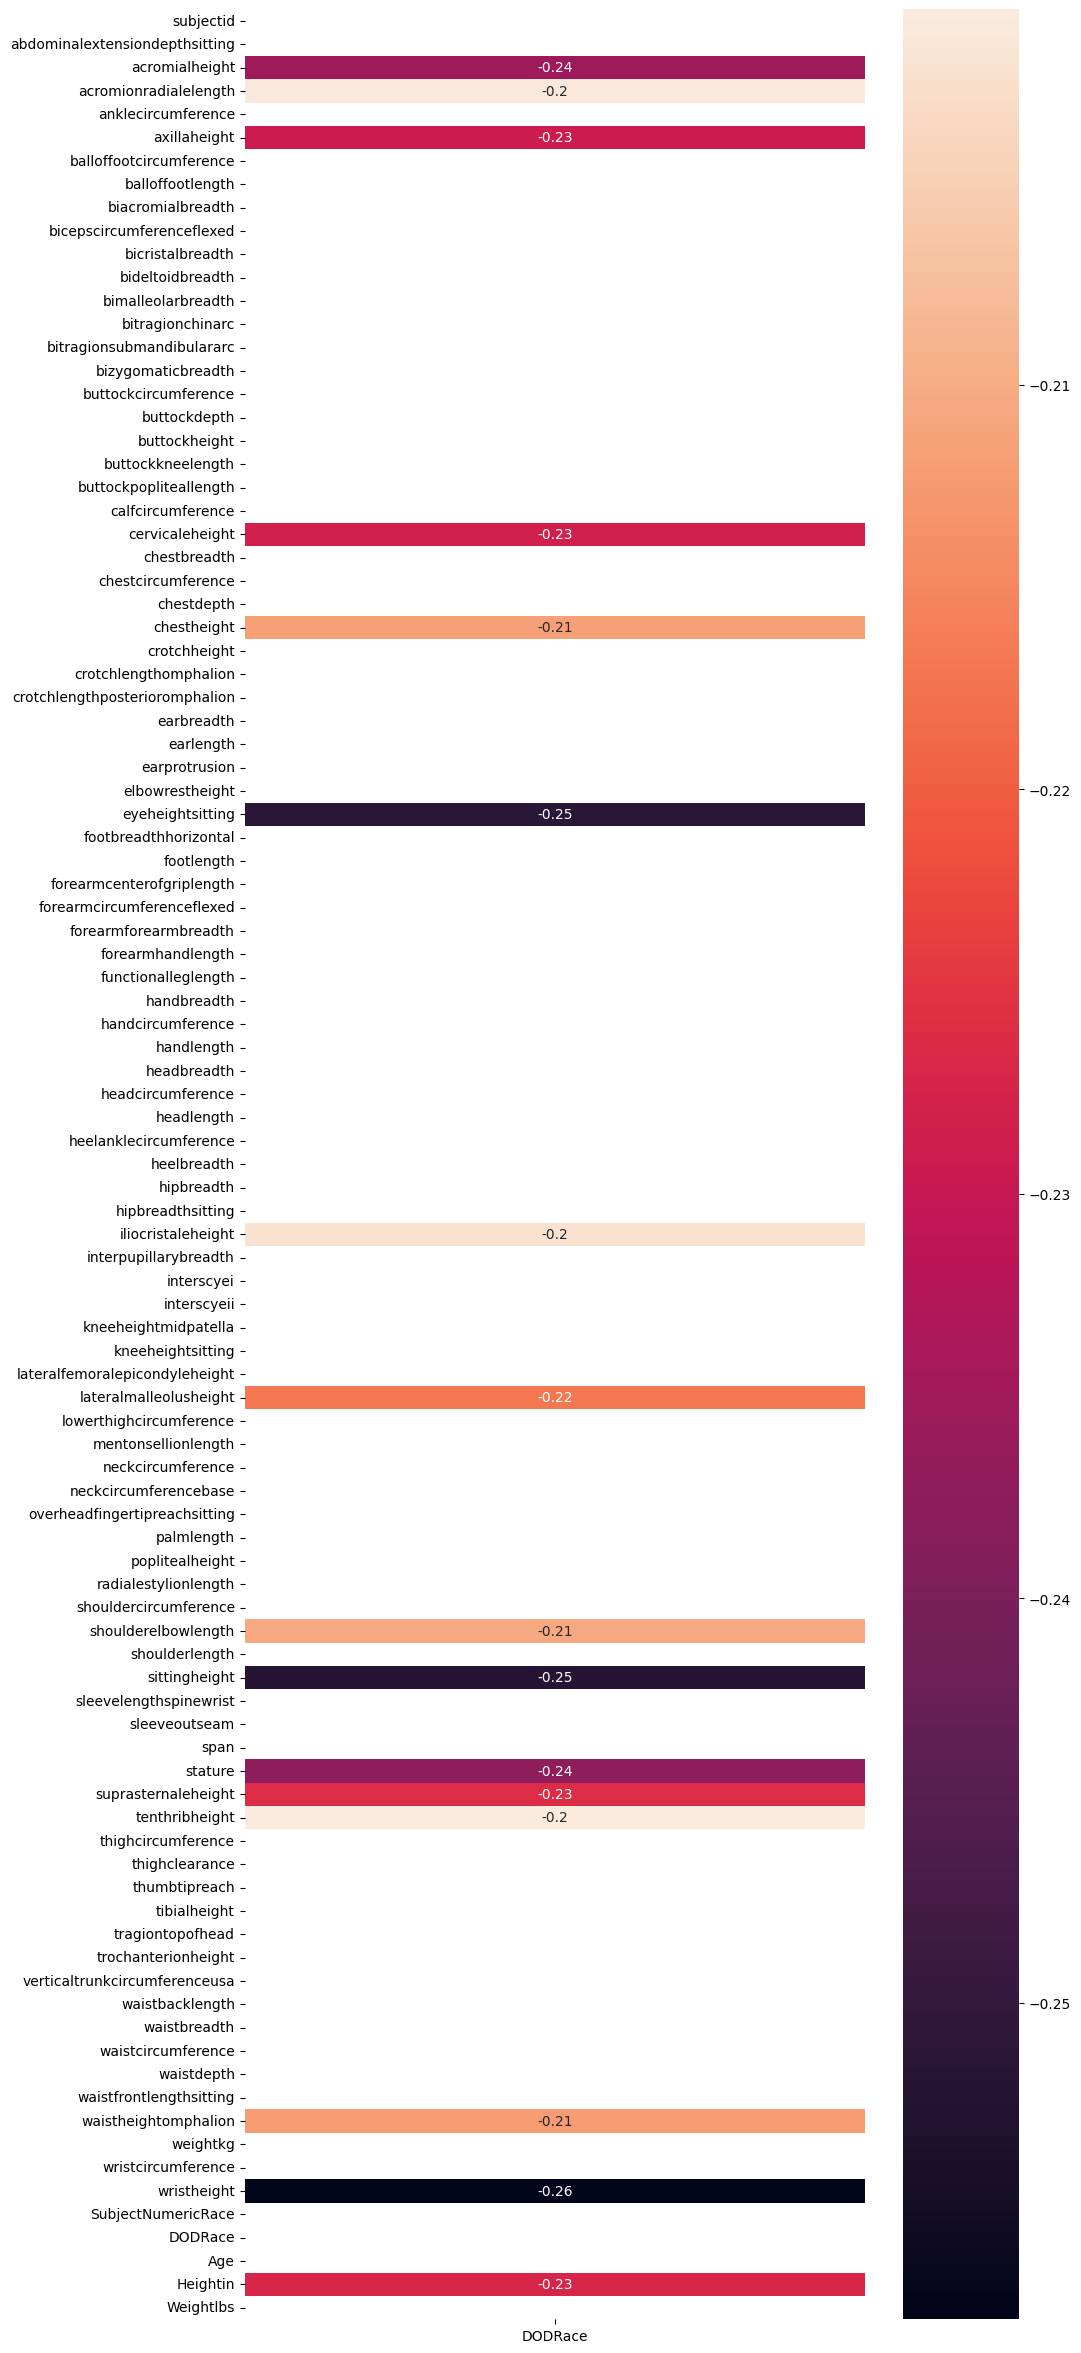

In [16]:
#corr = df3.corr()
#kot = corr[corr<=.4]
#plt.figure(figsize=(40,40))
#heat map for correlation coefficient
#sns.heatmap(kot, annot=True, fmt="0.1", vmin=-1, vmax=1)
#plt.figure(figsize=(40,70))
corr = df3.corr()[['DODRace']]

kot = corr[corr<=-.20]
plt.figure(figsize=(10,30))
sns.heatmap(kot, annot=True)

<AxesSubplot: >

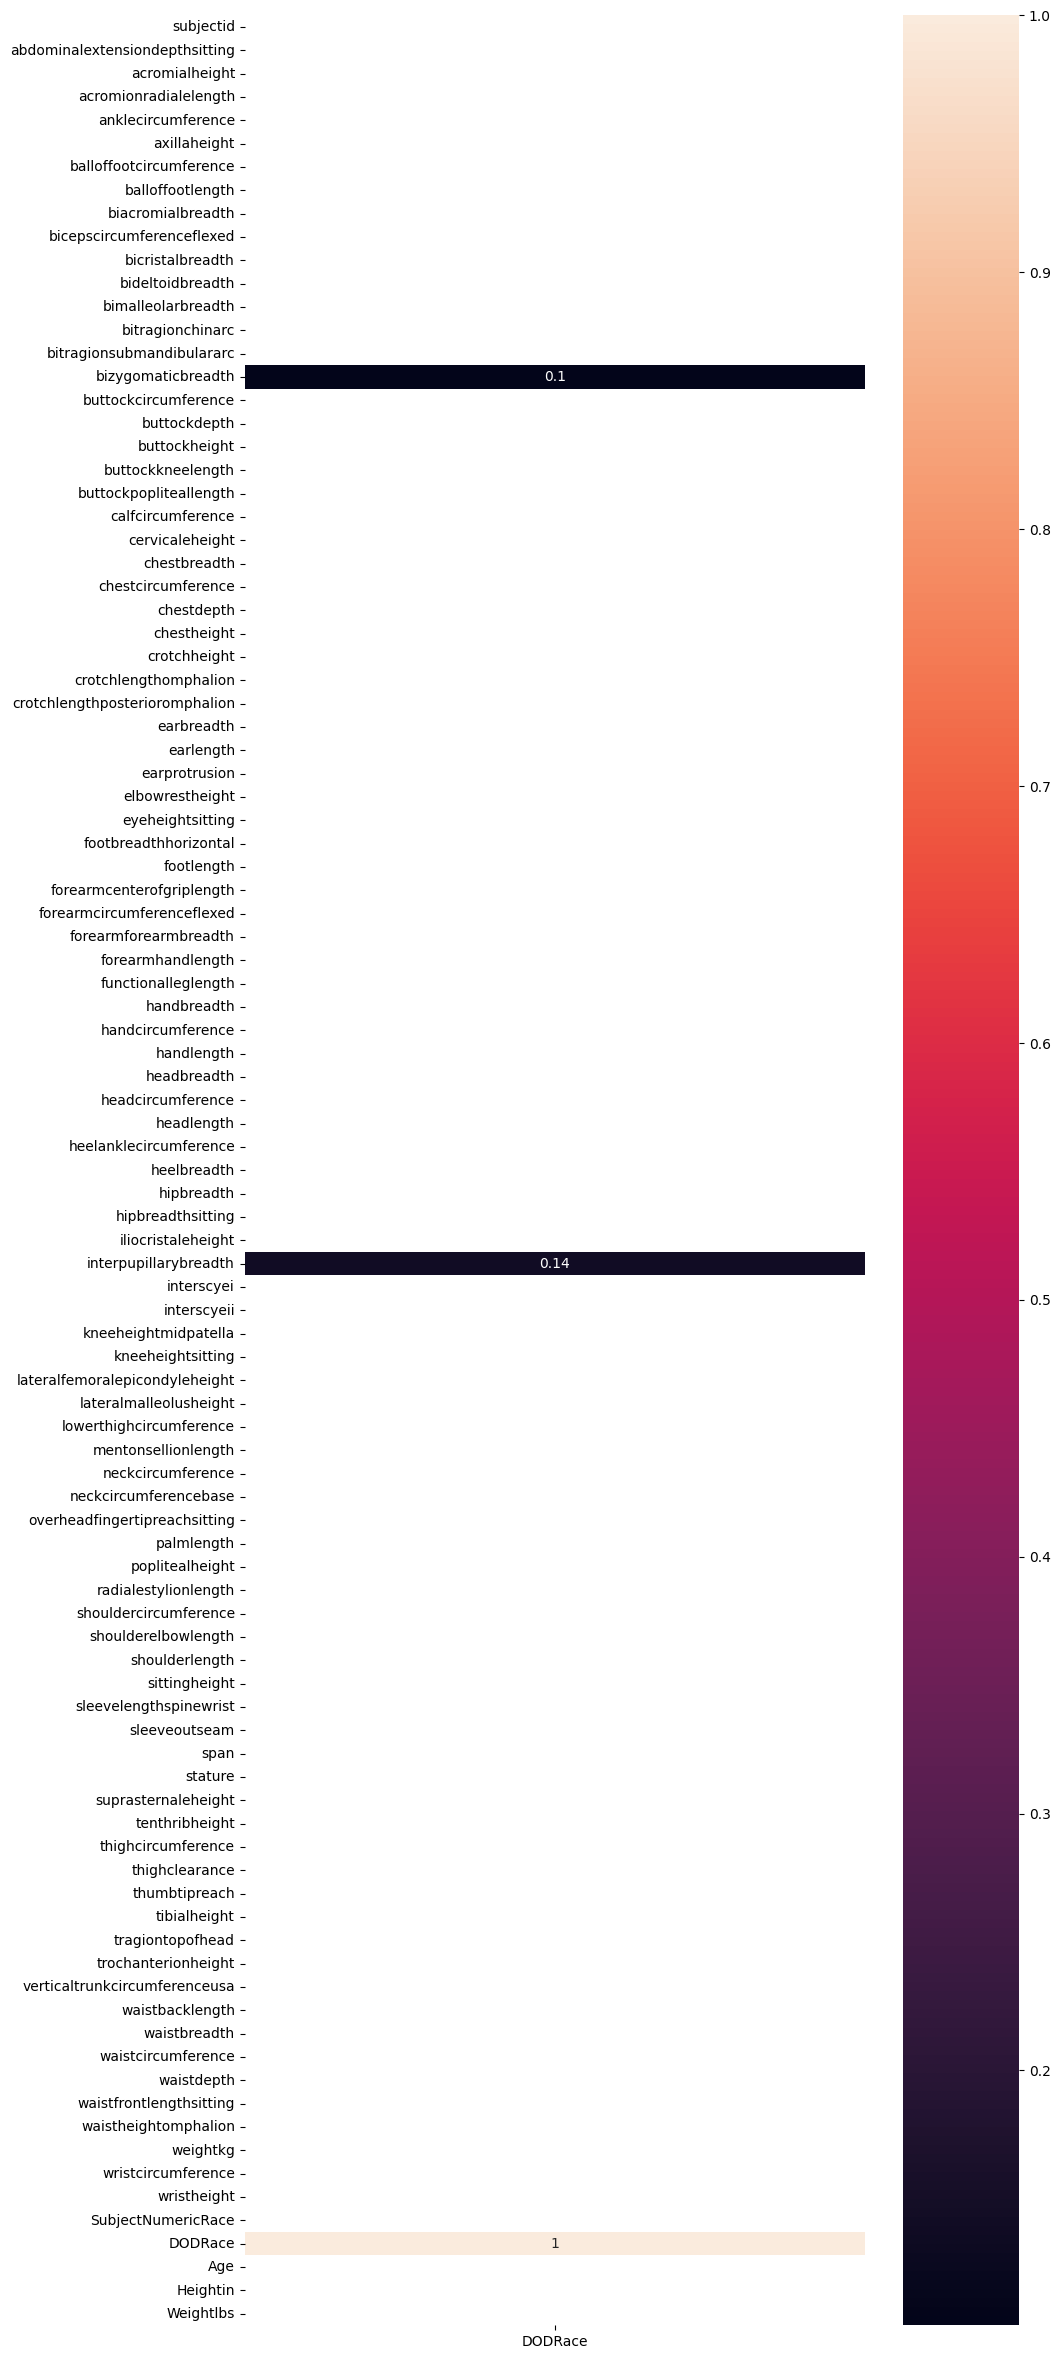

In [17]:
kot = corr[corr>=.1]
plt.figure (figsize=(10,30))
sns.heatmap (kot, annot=True)

In [18]:
df3['DODRace'].value_counts()

1    3792
2    1298
3     679
4     188
6      59
5      49
8       3
Name: DODRace, dtype: int64

In [19]:
df4=df3.replace({'DODRace': {1: 0, 2: 1, 3 :2}})

In [20]:
df4['DODRace'].value_counts()

0    3792
1    1298
2     679
4     188
6      59
5      49
8       3
Name: DODRace, dtype: int64

In [21]:
df5 = df4.loc[df4["DODRace"] <= 2]


In [22]:
df5.shape

(5769, 108)

In [23]:
df5.describe(include="object").T

,count,unique,top,freq
Gender,5769,2,Male,3899
Date,5769,253,5-Apr-12,43
Installation,5769,12,Camp Shelby,1111
Component,5769,3,Regular Army,2955
Branch,5769,3,Combat Service Support,3021
PrimaryMOS,5769,281,11B,641
SubjectsBirthLocation,5769,136,California,417
Ethnicity,1125,157,Mexican,356
WritingPreference,5769,3,Right hand,5088


In [24]:
df5['Gender']=df5['Gender'].map({'Male': 0, 'Female': 1})

In [25]:
df5.describe(include="object").T

,count,unique,top,freq
Date,5769,253,5-Apr-12,43
Installation,5769,12,Camp Shelby,1111
Component,5769,3,Regular Army,2955
Branch,5769,3,Combat Service Support,3021
PrimaryMOS,5769,281,11B,641
SubjectsBirthLocation,5769,136,California,417
Ethnicity,1125,157,Mexican,356
WritingPreference,5769,3,Right hand,5088


In [26]:
print(df5.columns.tolist())

['subjectid', 'abdominalextensiondepthsitting', 'acromialheight', 'acromionradialelength', 'anklecircumference', 'axillaheight', 'balloffootcircumference', 'balloffootlength', 'biacromialbreadth', 'bicepscircumferenceflexed', 'bicristalbreadth', 'bideltoidbreadth', 'bimalleolarbreadth', 'bitragionchinarc', 'bitragionsubmandibulararc', 'bizygomaticbreadth', 'buttockcircumference', 'buttockdepth', 'buttockheight', 'buttockkneelength', 'buttockpopliteallength', 'calfcircumference', 'cervicaleheight', 'chestbreadth', 'chestcircumference', 'chestdepth', 'chestheight', 'crotchheight', 'crotchlengthomphalion', 'crotchlengthposterioromphalion', 'earbreadth', 'earlength', 'earprotrusion', 'elbowrestheight', 'eyeheightsitting', 'footbreadthhorizontal', 'footlength', 'forearmcenterofgriplength', 'forearmcircumferenceflexed', 'forearmforearmbreadth', 'forearmhandlength', 'functionalleglength', 'handbreadth', 'handcircumference', 'handlength', 'headbreadth', 'headcircumference', 'headlength', 'heel

In [27]:
X= df5.drop(columns=['subjectid', 'abdominalextensiondepthsitting','anklecircumference','balloffootcircumference', 'balloffootlength', 'biacromialbreadth', 'bicepscircumferenceflexed', 
             'bicristalbreadth', 'bideltoidbreadth', 'bimalleolarbreadth', 'bitragionchinarc','bitragionsubmandibulararc', 'buttockcircumference', 'buttockdepth', 
             'buttockheight', 'buttockkneelength', 'buttockpopliteallength', 'calfcircumference','chestbreadth', 'chestcircumference', 'chestdepth','crotchheight', 'crotchlengthomphalion', 
             'crotchlengthposterioromphalion', 'earbreadth', 'earlength', 'earprotrusion', 'elbowrestheight', 'footbreadthhorizontal', 'footlength', 'forearmcenterofgriplength', 
             'forearmcircumferenceflexed', 'forearmforearmbreadth', 'forearmhandlength', 'functionalleglength', 'handbreadth', 'handcircumference', 'handlength', 'headbreadth', 
             'headcircumference', 'headlength', 'heelanklecircumference', 'heelbreadth', 'hipbreadth', 'hipbreadthsitting', 'interscyei', 'interscyeii', 'kneeheightmidpatella', 
             'kneeheightsitting', 'lateralfemoralepicondyleheight', 'lowerthighcircumference', 'mentonsellionlength', 'neckcircumference', 
             'neckcircumferencebase', 'overheadfingertipreachsitting', 'palmlength', 'poplitealheight', 'radialestylionlength', 'shouldercircumference','sleevelengthspinewrist', 
             'sleeveoutseam', 'span', 'thighcircumference', 'thighclearance', 'thumbtipreach', 'tibialheight', 'tragiontopofhead', 'trochanterionheight', 'verticaltrunkcircumferenceusa', 
             'waistbacklength', 'waistbreadth', 'waistcircumference', 'waistdepth', 'waistfrontlengthsitting','thighcircumference', 'thighclearance', 'thumbtipreach', 'tibialheight', 
             'tragiontopofhead', 'trochanterionheight', 'verticaltrunkcircumferenceusa', 'waistbacklength', 'waistbreadth', 'waistcircumference', 'waistdepth', 'waistfrontlengthsitting', 
             'Date', 'Installation', 'Component', 'Branch', 'PrimaryMOS', 'SubjectsBirthLocation', 'SubjectNumericRace', 'Ethnicity', 'DODRace','Weightlbs', 'Gender', 'WritingPreference'])
y= df5.DODRace

In [28]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
acromialheight,5769.0,1408.630265,78.303123,1146.0,1353.0,1412.0,1464.0,1683.0
acromionradialelength,5769.0,328.071590,20.444554,249.0,314.0,328.0,342.0,393.0
axillaheight,5769.0,1301.902583,71.260913,1062.0,1252.0,1304.0,1351.0,1553.0
bizygomaticbreadth,5769.0,139.529381,7.248670,116.0,134.0,140.0,145.0,166.0
cervicaleheight,5769.0,1479.952158,83.590746,1208.0,1421.0,1487.0,1539.0,1738.0
chestheight,5769.0,1254.290172,78.882449,1000.0,1199.0,1261.0,1310.0,1506.0
eyeheightsitting,5769.0,786.399203,41.843182,654.0,757.0,788.0,816.0,912.0
iliocristaleheight,5769.0,1042.152366,59.102058,816.0,1001.0,1042.0,1083.0,1253.0
interpupillarybreadth,5769.0,632.534928,36.644621,510.0,610.0,635.0,655.0,770.0
lateralmalleolusheight,5769.0,69.761830,7.245410,43.0,65.0,70.0,75.0,93.0


## Train | test split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=101)

In [30]:
def eval_metric(model, X_train, y_train, X_test, y_test):

    """ to get the metrics for the model """

    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

## Implement Logistic Regression

In [31]:
log= LogisticRegression(random_state=101)
log.fit(X_train, y_train)

LogisticRegression(random_state=101)

In [32]:
eval_metric(log, X_train, y_train, X_test, y_test)

Test_Set
[[717  38   3]
 [ 65 193   2]
 [101  28   7]]
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       758
           1       0.75      0.74      0.74       260
           2       0.58      0.05      0.09       136

    accuracy                           0.79      1154
   macro avg       0.71      0.58      0.57      1154
weighted avg       0.77      0.79      0.75      1154


Train_Set
[[2865  155   14]
 [ 272  761    5]
 [ 435   91   17]]
              precision    recall  f1-score   support

           0       0.80      0.94      0.87      3034
           1       0.76      0.73      0.74      1038
           2       0.47      0.03      0.06       543

    accuracy                           0.79      4615
   macro avg       0.68      0.57      0.56      4615
weighted avg       0.75      0.79      0.74      4615



In [33]:
operations = [("scaler", StandardScaler()), ("logistic", LogisticRegression())]

log_pipe = Pipeline(steps=operations)

log_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic', LogisticRegression())])

In [34]:
y_pred_1 = log_pipe.predict(X_test)
y_pred_1

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

<AxesSubplot: >

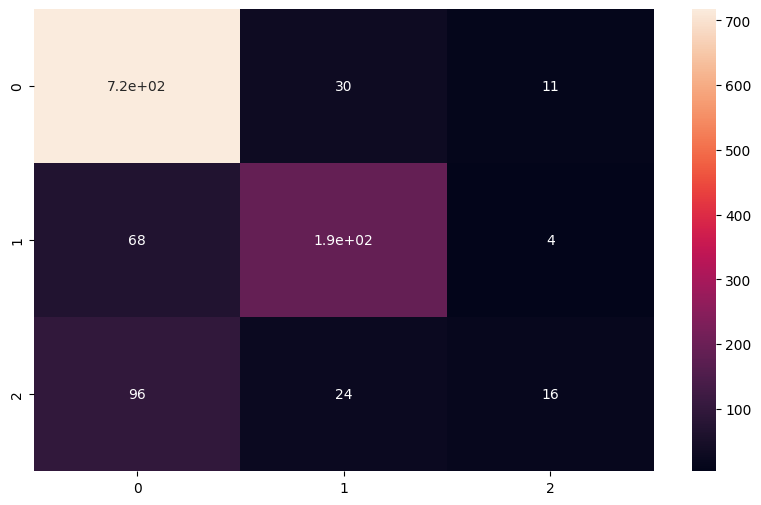

In [35]:
cm =confusion_matrix(y_test, y_pred_1)  
index = ['0','1','2']  
columns = ['0','1','2']  
cm_df = pd.DataFrame(cm,columns,index)                      
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True)

In [36]:
eval_metric(log_pipe, X_train, y_train, X_test, y_test) 

Test_Set
[[717  30  11]
 [ 68 188   4]
 [ 96  24  16]]
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       758
           1       0.78      0.72      0.75       260
           2       0.52      0.12      0.19       136

    accuracy                           0.80      1154
   macro avg       0.70      0.60      0.61      1154
weighted avg       0.77      0.80      0.77      1154


Train_Set
[[2859  145   30]
 [ 254  768   16]
 [ 400   78   65]]
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      3034
           1       0.77      0.74      0.76      1038
           2       0.59      0.12      0.20       543

    accuracy                           0.80      4615
   macro avg       0.72      0.60      0.61      4615
weighted avg       0.78      0.80      0.77      4615



## GridSearchCV

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

operations = [("scaler", StandardScaler()), ("logistic", LogisticRegression())]

log_pipe = Pipeline(steps=operations)

penalty = ["l2","l1"]
C = [0.01, 0.012, 0.1] 
class_weight= ["balanced", None] 


solver = ["lbfgs", "liblinear"] #"sag", "saga"

param_grid = {"logistic__penalty" : penalty,
              "logistic__C" : C,
              "logistic__class_weight":class_weight,
              "logistic__solver":solver}



cv = StratifiedKFold(n_splits = 10) 

grid_model = GridSearchCV(estimator=log_pipe,
                          param_grid=param_grid,
                          cv=cv,
                          scoring = "recall",   
                          n_jobs = -1,
                          return_train_score=True)

In [38]:
grid_model.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.01, 0.012, 0.1],
                         'logistic__class_weight': ['balanced', None],
                         'logistic__penalty': ['l2', 'l1'],
                         'logistic__solver': ['lbfgs', 'liblinear']},
             return_train_score=True, scoring='recall')

In [39]:
grid_model.best_params_

{'logistic__C': 0.01,
 'logistic__class_weight': 'balanced',
 'logistic__penalty': 'l2',
 'logistic__solver': 'lbfgs'}

In [40]:
eval_metric(grid_model, X_train, y_train, X_test, y_test)  

Test_Set
[[504  74 180]
 [ 23 203  34]
 [ 39  28  69]]
              precision    recall  f1-score   support

           0       0.89      0.66      0.76       758
           1       0.67      0.78      0.72       260
           2       0.24      0.51      0.33       136

    accuracy                           0.67      1154
   macro avg       0.60      0.65      0.60      1154
weighted avg       0.76      0.67      0.70      1154


Train_Set
[[1999  291  744]
 [ 103  801  134]
 [ 156   80  307]]
              precision    recall  f1-score   support

           0       0.89      0.66      0.76      3034
           1       0.68      0.77      0.72      1038
           2       0.26      0.57      0.36       543

    accuracy                           0.67      4615
   macro avg       0.61      0.67      0.61      4615
weighted avg       0.77      0.67      0.70      4615



In [41]:
y_pred_test = grid_model.predict(X_test)
y_pred_train = grid_model.predict(X_train)

log_accuracy_test = accuracy_score(y_test, y_pred_test)
log_accuracy_train = accuracy_score(y_train, y_pred_train)

log_f1_test = f1_score(y_test, y_pred_test, average='macro')
log_f1_train = f1_score(y_train, y_pred_train, average='macro')

log_accuracy_test, log_accuracy_train, log_f1_test, log_f1_train

(0.6724436741767764,
 0.6732394366197183,
 0.6030896615080991,
 0.6118969738892709)

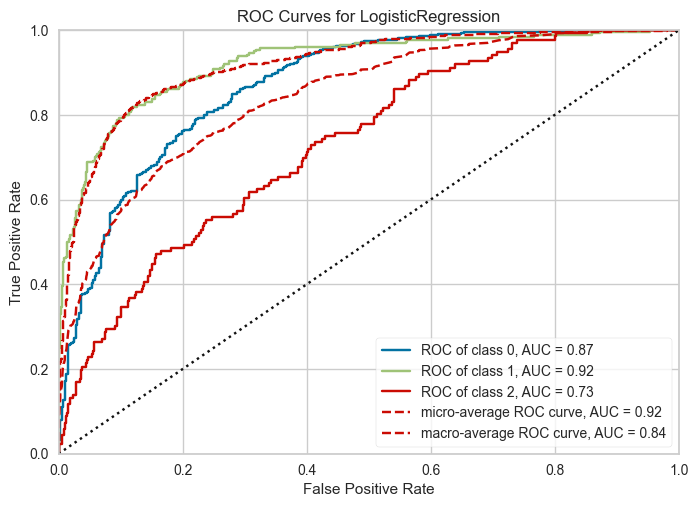

In [42]:
from yellowbrick.classifier import ROCAUC

rf_model = LogisticRegression ()
visualizer = ROCAUC(rf_model)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();  

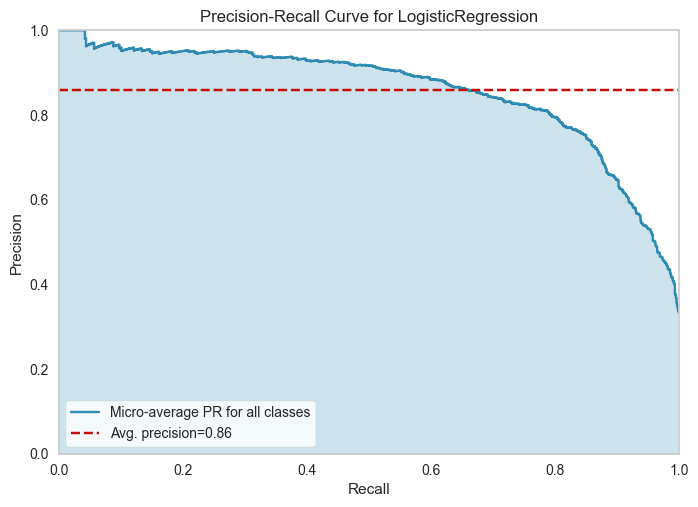

In [43]:
from yellowbrick.classifier import PrecisionRecallCurve

rf_model =LogisticRegression()
visualizer = PrecisionRecallCurve(rf_model)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();  

## Implement DecisionTree

In [44]:
dtree = DecisionTreeClassifier(random_state=101)

In [45]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=101)

In [46]:
eval_metric(dtree, X_train, y_train, X_test, y_test)

Test_Set
[[567  94  97]
 [ 88 147  25]
 [ 82  29  25]]
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       758
           1       0.54      0.57      0.55       260
           2       0.17      0.18      0.18       136

    accuracy                           0.64      1154
   macro avg       0.49      0.50      0.50      1154
weighted avg       0.65      0.64      0.64      1154


Train_Set
[[3034    0    0]
 [   0 1038    0]
 [   0    0  543]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3034
           1       1.00      1.00      1.00      1038
           2       1.00      1.00      1.00       543

    accuracy                           1.00      4615
   macro avg       1.00      1.00      1.00      4615
weighted avg       1.00      1.00      1.00      4615



In [47]:
y_pred = dtree.predict(X_test)
y_train_pred = dtree.predict(X_train)

<AxesSubplot: >

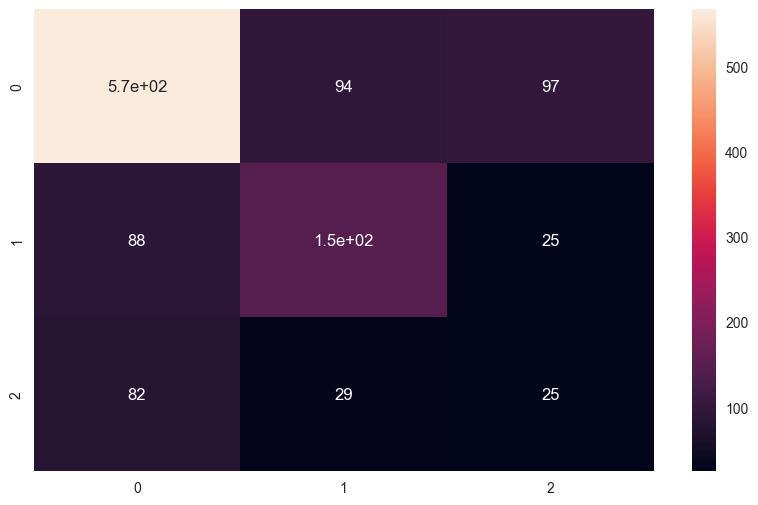

In [48]:
cm =confusion_matrix(y_test, y_pred)  
index = ['0','1','2']  
columns = ['0','1','2']  
cm_df = pd.DataFrame(cm,columns,index)                      
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True)

In [49]:
eval_metric(dtree, X_train, y_train, X_test, y_test)

Test_Set
[[567  94  97]
 [ 88 147  25]
 [ 82  29  25]]
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       758
           1       0.54      0.57      0.55       260
           2       0.17      0.18      0.18       136

    accuracy                           0.64      1154
   macro avg       0.49      0.50      0.50      1154
weighted avg       0.65      0.64      0.64      1154


Train_Set
[[3034    0    0]
 [   0 1038    0]
 [   0    0  543]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3034
           1       1.00      1.00      1.00      1038
           2       1.00      1.00      1.00       543

    accuracy                           1.00      4615
   macro avg       1.00      1.00      1.00      4615
weighted avg       1.00      1.00      1.00      4615



In [50]:
scores = cross_validate(dtree, X_train, y_train, scoring = ["accuracy", "precision_micro", "recall_micro", "f1_micro"], 
                        cv = 10, return_train_score=True)

df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores

,fit_time,score_time,test_accuracy,train_accuracy,test_precision_micro,train_precision_micro,test_recall_micro,train_recall_micro,test_f1_micro,train_f1_micro
1,0.121951,0.009996,0.645022,1.0,0.645022,1.0,0.645022,1.0,0.645022,1.0
2,0.087963,0.006018,0.660173,1.0,0.660173,1.0,0.660173,1.0,0.660173,1.0
3,0.087967,0.007996,0.638528,1.0,0.638528,1.0,0.638528,1.0,0.638528,1.0
4,0.092983,0.005995,0.664502,1.0,0.664502,1.0,0.664502,1.0,0.664502,1.0
5,0.094980,0.006977,0.627706,1.0,0.627706,1.0,0.627706,1.0,0.627706,1.0
6,0.089959,0.010016,0.652928,1.0,0.652928,1.0,0.652928,1.0,0.652928,1.0
7,0.098866,0.015993,0.646421,1.0,0.646421,1.0,0.646421,1.0,0.646421,1.0
8,0.155936,0.008996,0.639913,1.0,0.639913,1.0,0.639913,1.0,0.639913,1.0
9,0.251895,0.009997,0.626898,1.0,0.626898,1.0,0.626898,1.0,0.626898,1.0
10,0.093961,0.006997,0.655098,1.0,0.655098,1.0,0.655098,1.0,0.655098,1.0


In [51]:
df_scores.mean()[2:]

test_accuracy            0.645719
train_accuracy           1.000000
test_precision_micro     0.645719
train_precision_micro    1.000000
test_recall_micro        0.645719
train_recall_micro       1.000000
test_f1_micro            0.645719
train_f1_micro           1.000000
dtype: float64

In [52]:
from sklearn.tree import plot_tree


In [53]:
def report_model(model):
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print('\n')
    print(eval_metric(model, X_train, y_train, X_test, y_test))
    print('\n')
    plt.figure(figsize=(12,8),dpi=100)
    plot_tree(model,filled=True, feature_names=X.columns, fontsize=10);

In [54]:
param_grid = {"splitter":["best", "random"],
              "max_features":[None, "auto"],
              "max_depth": [None, 2, 3],
              "min_samples_leaf": [3,4,5],
              "min_samples_split": [3,5,6],
              'class_weight': [None, "balanced"]}

## GridSearch DesisionTree

In [55]:
grid_model = GridSearchCV(estimator=dtree,
                          param_grid=param_grid,
                          scoring='recall',
                          cv=10,
                          n_jobs = -1,
                          return_train_score=True)

In [56]:
grid_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=101),
             n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [None, 2, 3],
                         'max_features': [None, 'auto'],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [3, 5, 6],
                         'splitter': ['best', 'random']},
             return_train_score=True, scoring='recall')

In [57]:
grid_model.best_estimator_

DecisionTreeClassifier(min_samples_leaf=3, min_samples_split=3,
                       random_state=101)

In [58]:
model_dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=5,
                       min_samples_split=5, splitter='random')

In [59]:
model_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=5, min_samples_split=5,
                       splitter='random')

In [60]:
y_pred_test = model_dt.predict(X_test)
y_pred_train =model_dt.predict(X_train)

dt_accuracy_test = accuracy_score(y_test, y_pred_test)
dt_accuracy_train = accuracy_score(y_train, y_pred_train)

dt_f1_test = f1_score(y_test, y_pred_test, average='macro')
dt_f1_train = f1_score(y_train, y_pred_train, average='macro')

dt_accuracy_test, dt_accuracy_train, dt_f1_test, dt_f1_train

(0.7365684575389948,
 0.7505958829902492,
 0.49584554943503373,
 0.5222197412210442)



Test_Set
[[702  48   8]
 [116 144   0]
 [101  31   4]]
              precision    recall  f1-score   support

           0       0.76      0.93      0.84       758
           1       0.65      0.55      0.60       260
           2       0.33      0.03      0.05       136

    accuracy                           0.74      1154
   macro avg       0.58      0.50      0.50      1154
weighted avg       0.69      0.74      0.69      1154


Train_Set
[[2840  174   20]
 [ 441  593    4]
 [ 392  120   31]]
              precision    recall  f1-score   support

           0       0.77      0.94      0.85      3034
           1       0.67      0.57      0.62      1038
           2       0.56      0.06      0.10       543

    accuracy                           0.75      4615
   macro avg       0.67      0.52      0.52      4615
weighted avg       0.73      0.75      0.71      4615

None




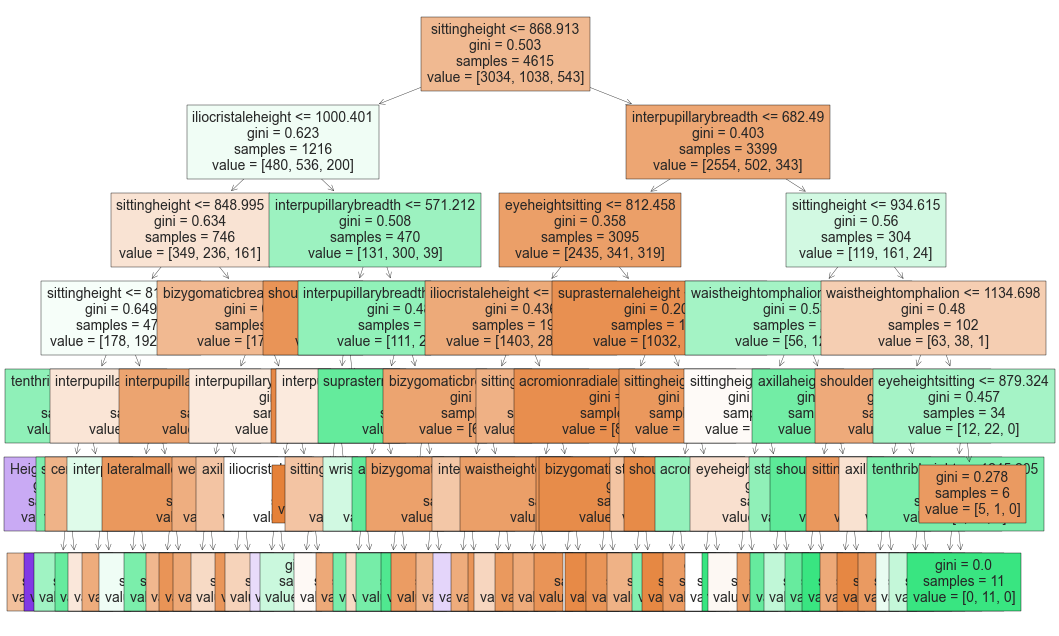

In [61]:
report_model(model_dt)
plt.show()

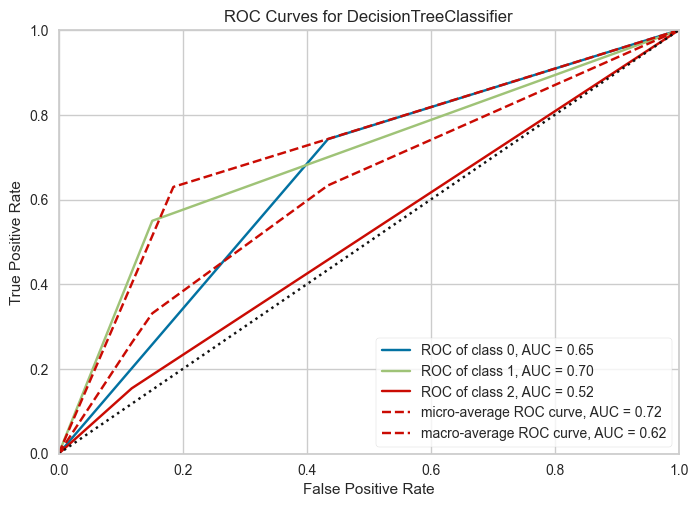

In [62]:
from yellowbrick.classifier import ROCAUC

rf_model =  DecisionTreeClassifier ()
visualizer = ROCAUC(rf_model)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();  

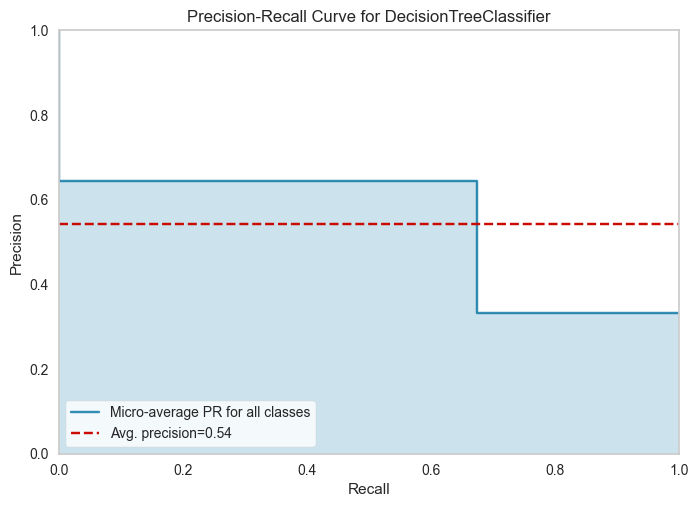

In [63]:
from yellowbrick.classifier import PrecisionRecallCurve

rf_model = DecisionTreeClassifier()
visualizer = PrecisionRecallCurve(rf_model)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();  

## Implement Random Forest

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
rf= RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)
eval_metric(rf, X_train, y_train, X_test, y_test)

Test_Set
[[721  32   5]
 [ 95 164   1]
 [107  20   9]]
              precision    recall  f1-score   support

           0       0.78      0.95      0.86       758
           1       0.76      0.63      0.69       260
           2       0.60      0.07      0.12       136

    accuracy                           0.77      1154
   macro avg       0.71      0.55      0.56      1154
weighted avg       0.75      0.77      0.73      1154


Train_Set
[[3034    0    0]
 [   0 1038    0]
 [   0    0  543]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3034
           1       1.00      1.00      1.00      1038
           2       1.00      1.00      1.00       543

    accuracy                           1.00      4615
   macro avg       1.00      1.00      1.00      4615
weighted avg       1.00      1.00      1.00      4615



In [66]:
scores = cross_validate(rf, X_train, y_train, scoring = ["accuracy", "precision_micro", "recall_micro", "f1_micro"], 
                        cv = 10, return_train_score=True)

df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores

,fit_time,score_time,test_accuracy,train_accuracy,test_precision_micro,train_precision_micro,test_recall_micro,train_recall_micro,test_f1_micro,train_f1_micro
1,2.274907,0.033080,0.785714,1.0,0.785714,1.0,0.785714,1.0,0.785714,1.0
2,1.977335,0.032988,0.759740,1.0,0.759740,1.0,0.759740,1.0,0.759740,1.0
3,2.126041,0.033986,0.772727,1.0,0.772727,1.0,0.772727,1.0,0.772727,1.0
4,2.046954,0.043977,0.766234,1.0,0.766234,1.0,0.766234,1.0,0.766234,1.0
5,1.979272,0.039984,0.746753,1.0,0.746753,1.0,0.746753,1.0,0.746753,1.0
6,2.047548,0.033986,0.767896,1.0,0.767896,1.0,0.767896,1.0,0.767896,1.0
7,2.154112,0.033964,0.774403,1.0,0.774403,1.0,0.774403,1.0,0.774403,1.0
8,1.954020,0.034010,0.759219,1.0,0.759219,1.0,0.759219,1.0,0.759219,1.0
9,2.051449,0.049981,0.759219,1.0,0.759219,1.0,0.759219,1.0,0.759219,1.0
10,1.943399,0.036975,0.778742,1.0,0.778742,1.0,0.778742,1.0,0.778742,1.0


In [67]:
df_scores.mean()[2:]

test_accuracy            0.767065
train_accuracy           1.000000
test_precision_micro     0.767065
train_precision_micro    1.000000
test_recall_micro        0.767065
train_recall_micro       1.000000
test_f1_micro            0.767065
train_f1_micro           1.000000
dtype: float64

In [68]:
param_grid = {'n_estimators':[200, 300],     
             'max_features':[None, "auto"],
             'max_depth':[6,7],
             'min_samples_split':[5,6]}

In [69]:
model = RandomForestClassifier(class_weight = "balanced", random_state=42)
rf_grid_model = GridSearchCV(model, param_grid, scoring = "accuracy", n_jobs = -1, verbose = 2).fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [70]:
rf_grid_model.best_params_

{'max_depth': 7,
 'max_features': None,
 'min_samples_split': 5,
 'n_estimators': 200}

In [71]:
eval_metric(rf_grid_model, X_train, y_train, X_test, y_test)

Test_Set
[[570  74 114]
 [ 50 188  22]
 [ 53  30  53]]
              precision    recall  f1-score   support

           0       0.85      0.75      0.80       758
           1       0.64      0.72      0.68       260
           2       0.28      0.39      0.33       136

    accuracy                           0.70      1154
   macro avg       0.59      0.62      0.60      1154
weighted avg       0.73      0.70      0.72      1154


Train_Set
[[2365  220  449]
 [ 121  848   69]
 [ 109   30  404]]
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      3034
           1       0.77      0.82      0.79      1038
           2       0.44      0.74      0.55       543

    accuracy                           0.78      4615
   macro avg       0.71      0.78      0.73      4615
weighted avg       0.82      0.78      0.80      4615



In [72]:
y_pred_test = rf_grid_model.predict(X_test)
y_pred_train =rf_grid_model.predict(X_train)

rf_accuracy_test = accuracy_score(y_test, y_pred_test)
rf_accuracy_train = accuracy_score(y_train, y_pred_train)

rf_f1_test = f1_score(y_test, y_pred_test, average='macro')
rf_f1_train = f1_score(y_train, y_pred_train, average='macro')

rf_accuracy_test, rf_accuracy_train, rf_f1_test, rf_f1_train

(0.7027729636048526, 0.7837486457204768, 0.601319656249927, 0.7286115583962225)

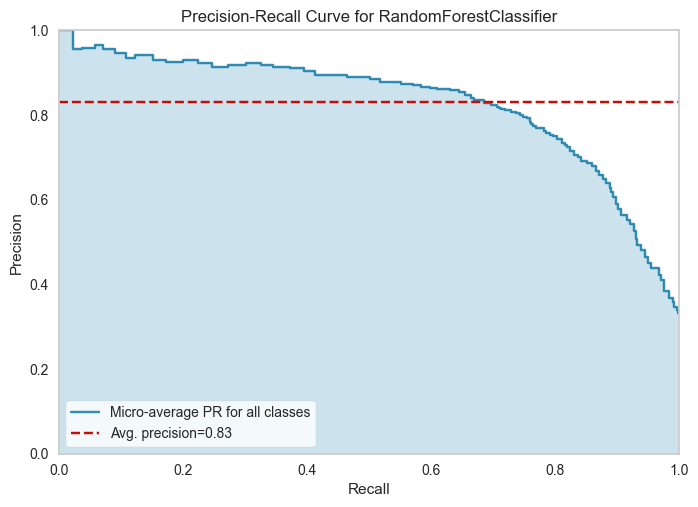

In [73]:
from yellowbrick.classifier import PrecisionRecallCurve

rf_model = RandomForestClassifier()
visualizer = PrecisionRecallCurve(rf_model)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();  

## SupportVectorMachine

In [74]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [75]:
svc= SVC(random_state=42)
svc.fit(X_train,y_train)

SVC(random_state=42)

In [76]:

eval_metric(svc, X_train, y_train, X_test, y_test)

Test_Set
[[758   0   0]
 [238  22   0]
 [136   0   0]]
              precision    recall  f1-score   support

           0       0.67      1.00      0.80       758
           1       1.00      0.08      0.16       260
           2       0.00      0.00      0.00       136

    accuracy                           0.68      1154
   macro avg       0.56      0.36      0.32      1154
weighted avg       0.67      0.68      0.56      1154


Train_Set
[[3033    1    0]
 [ 956   82    0]
 [ 542    1    0]]
              precision    recall  f1-score   support

           0       0.67      1.00      0.80      3034
           1       0.98      0.08      0.15      1038
           2       0.00      0.00      0.00       543

    accuracy                           0.67      4615
   macro avg       0.55      0.36      0.32      4615
weighted avg       0.66      0.67      0.56      4615



In [77]:
operations = [("scaler", StandardScaler()), ("svc", SVC(random_state=42))]
pipe_model = Pipeline(steps=operations)

In [78]:
pipe_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(random_state=42))])

In [79]:
eval_metric(pipe_model, X_train, y_train, X_test, y_test)

Test_Set
[[720  33   5]
 [ 79 180   1]
 [110  25   1]]
              precision    recall  f1-score   support

           0       0.79      0.95      0.86       758
           1       0.76      0.69      0.72       260
           2       0.14      0.01      0.01       136

    accuracy                           0.78      1154
   macro avg       0.56      0.55      0.53      1154
weighted avg       0.71      0.78      0.73      1154


Train_Set
[[2924  104    6]
 [ 285  750    3]
 [ 446   67   30]]
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      3034
           1       0.81      0.72      0.77      1038
           2       0.77      0.06      0.10       543

    accuracy                           0.80      4615
   macro avg       0.79      0.58      0.58      4615
weighted avg       0.80      0.80      0.76      4615



In [80]:
operations = [("scaler", StandardScaler()), ("SVC", SVC(random_state=101))]
pipe_model = Pipeline(steps=operations)

scores = cross_validate(pipe_model, X_train, y_train, scoring = ['accuracy', 'precision_micro','recall_micro','f1_micro'], cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))


In [81]:
df_scores

,fit_time,score_time,test_accuracy,train_accuracy,test_precision_micro,train_precision_micro,test_recall_micro,train_recall_micro,test_f1_micro,train_f1_micro
1,1.407536,0.208239,0.800866,0.798941,0.800866,0.798941,0.800866,0.798941,0.800866,0.798941
2,1.208413,0.178972,0.783550,0.805201,0.783550,0.805201,0.783550,0.805201,0.783550,0.805201
3,1.252018,0.273228,0.792208,0.800385,0.792208,0.800385,0.792208,0.800385,0.792208,0.800385
4,1.109629,0.206295,0.785714,0.800867,0.785714,0.800867,0.785714,0.800867,0.785714,0.800867
5,1.183090,0.195974,0.757576,0.803997,0.757576,0.803997,0.757576,0.803997,0.757576,0.803997
6,1.159445,0.212996,0.802603,0.803563,0.802603,0.803563,0.802603,0.803563,0.802603,0.803563
7,1.281999,0.404829,0.787419,0.801637,0.787419,0.801637,0.787419,0.801637,0.787419,0.801637
8,1.377875,0.278952,0.787419,0.802118,0.787419,0.802118,0.787419,0.802118,0.787419,0.802118
9,1.025746,0.350753,0.770065,0.803563,0.770065,0.803563,0.770065,0.803563,0.770065,0.803563
10,1.043874,0.186912,0.796095,0.801156,0.796095,0.801156,0.796095,0.801156,0.796095,0.801156


In [82]:
df_scores.mean()[2:]

test_accuracy            0.786351
train_accuracy           0.802143
test_precision_micro     0.786351
train_precision_micro    0.802143
test_recall_micro        0.786351
train_recall_micro       0.802143
test_f1_micro            0.786351
train_f1_micro           0.802143
dtype: float64

In [83]:
from sklearn.model_selection import GridSearchCV

In [84]:
param_grid = {'SVC__C': [0.001, 0.01],
              'SVC__gamma': [ 0.2, 0.3],
              'SVC__kernel': ['poly','rbf']}

In [85]:
operations = [("scaler", StandardScaler()), ("SVC", SVC(probability=True, class_weight="balanced", random_state=42))]
pipe_model = Pipeline(steps=operations)
svm_model_grid = GridSearchCV(pipe_model, param_grid, scoring="accuracy",n_jobs = -1, cv=5).fit(X_train, y_train)

In [86]:
svm_model_grid.best_params_

{'SVC__C': 0.01, 'SVC__gamma': 0.2, 'SVC__kernel': 'poly'}

In [87]:
eval_metric(svm_model_grid, X_train, y_train, X_test, y_test)

Test_Set
[[620  43  95]
 [ 54 165  41]
 [ 67  20  49]]
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       758
           1       0.72      0.63      0.68       260
           2       0.26      0.36      0.31       136

    accuracy                           0.72      1154
   macro avg       0.61      0.60      0.60      1154
weighted avg       0.74      0.72      0.73      1154


Train_Set
[[2469  162  403]
 [ 205  708  125]
 [ 250   41  252]]
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      3034
           1       0.78      0.68      0.73      1038
           2       0.32      0.46      0.38       543

    accuracy                           0.74      4615
   macro avg       0.65      0.65      0.65      4615
weighted avg       0.77      0.74      0.75      4615



In [88]:
y_pred_test = svm_model_grid.predict(X_test)
y_pred_train =svm_model_grid.predict(X_train)

svm_accuracy_test = accuracy_score(y_test, y_pred_test)
svm_accuracy_train = accuracy_score(y_train, y_pred_train)

svm_f1_test = f1_score(y_test, y_pred_test, average='macro')
svm_f1_train = f1_score(y_train, y_pred_train, average='macro')

svm_accuracy_test, svm_accuracy_train, svm_f1_test, svm_f1_train

(0.7227036395147314, 0.743011917659805, 0.6029145345942571, 0.6454268053461379)

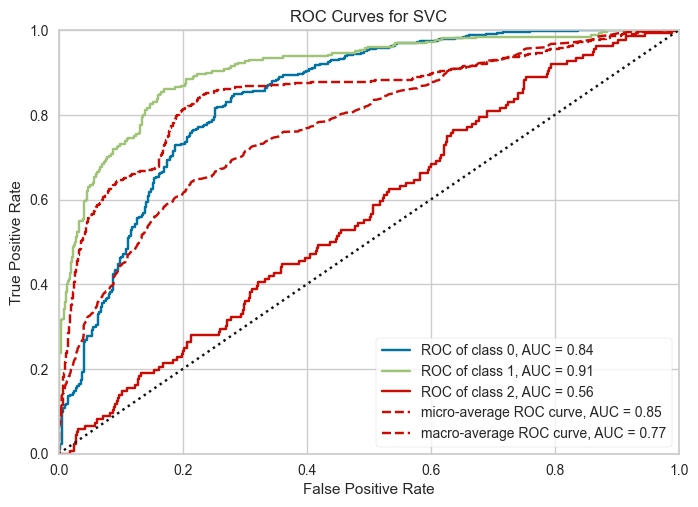

In [89]:
from yellowbrick.classifier import ROCAUC

rf_model = SVC()
visualizer = ROCAUC(rf_model)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();  

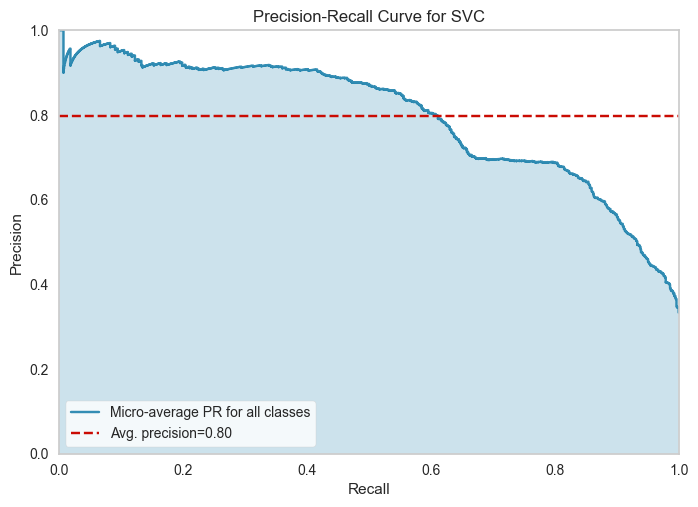

In [90]:
from yellowbrick.classifier import PrecisionRecallCurve

rf_model = SVC()
visualizer = PrecisionRecallCurve(rf_model)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();  

## Implement XGBOOST

In [91]:
xgb = XGBClassifier(random_state=101)
xgb.fit(X_train, y_train)

NameError: name 'XGBClassifier' is not defined

In [ ]:

eval_metric(xgb, X_train, y_train, X_test, y_test)

Test_Set
[[698  41  19]
 [ 76 176   8]
 [102  20  14]]
              precision    recall  f1-score   support

           0       0.80      0.92      0.85       758
           1       0.74      0.68      0.71       260
           2       0.34      0.10      0.16       136

    accuracy                           0.77      1154
   macro avg       0.63      0.57      0.57      1154
weighted avg       0.73      0.77      0.74      1154


Train_Set
[[3034    0    0]
 [   1 1037    0]
 [   0    0  543]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3034
           1       1.00      1.00      1.00      1038
           2       1.00      1.00      1.00       543

    accuracy                           1.00      4615
   macro avg       1.00      1.00      1.00      4615
weighted avg       1.00      1.00      1.00      4615



In [ ]:
param_grid = {"booster":['dart','gbtree'],"eta":[0.1,0.2],"n_estimators":[100,200],'max_depth':[3], "learning_rate": [0.1],
             "subsample":[0.5], "colsample_bytree":[0.5], 'reg_alpha':[0,1]}

xgb_model = XGBClassifier()
xgb_grid = GridSearchCV(xgb_model, param_grid, scoring = "accuracy", verbose=2, n_jobs = -1, 
                        return_train_score=True)
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'booster': ['dart', 'gbtree'],
                         'colsample_bytree': [0.5], 'eta': [0.1, 0.2],
                         'learning_rate': [0.1], 'max_depth': [3],
                         'n_estimators': [100, 200], 'reg_alpha': [0, 1],
                         'subsample': [0.5]},
             return_train_score=True, scoring='accuracy', verbose=2)

In [ ]:
xgb_grid.best_params_

{'booster': 'gbtree',
 'colsample_bytree': 0.5,
 'eta': 0.1,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 200,
 'reg_alpha': 1,
 'subsample': 0.5}

In [ ]:
xgb_grid.best_score_

0.7811484290357529

In [ ]:
eval_metric(xgb_grid, X_train, y_train, X_test, y_test)

Test_Set
[[710  37  11]
 [ 72 182   6]
 [100  22  14]]
              precision    recall  f1-score   support

           0       0.80      0.94      0.87       758
           1       0.76      0.70      0.73       260
           2       0.45      0.10      0.17       136

    accuracy                           0.79      1154
   macro avg       0.67      0.58      0.59      1154
weighted avg       0.75      0.79      0.75      1154


Train_Set
[[2925   95   14]
 [ 240  790    8]
 [ 354   57  132]]
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      3034
           1       0.84      0.76      0.80      1038
           2       0.86      0.24      0.38       543

    accuracy                           0.83      4615
   macro avg       0.84      0.66      0.69      4615
weighted avg       0.84      0.83      0.81      4615



In [ ]:
xgb_grid.best_params_

{'booster': 'gbtree',
 'colsample_bytree': 0.5,
 'eta': 0.1,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 200,
 'reg_alpha': 1,
 'subsample': 0.5}

In [ ]:
y_pred_test = xgb_grid.predict(X_test)
y_pred_train =xgb_grid.predict(X_train)

xgb_accuracy_test = accuracy_score(y_test, y_pred_test)
xgb_accuracy_train = accuracy_score(y_train, y_pred_train)

xgb_f1_test = f1_score(y_test, y_pred_test, average='macro')
xgb_f1_train = f1_score(y_train, y_pred_train, average='macro')

xgb_accuracy_test, xgb_accuracy_train, xgb_f1_test, xgb_f1_train

(0.7850953206239168,
 0.8335861321776815,
 0.5866884117942975,
 0.6898222765924178)

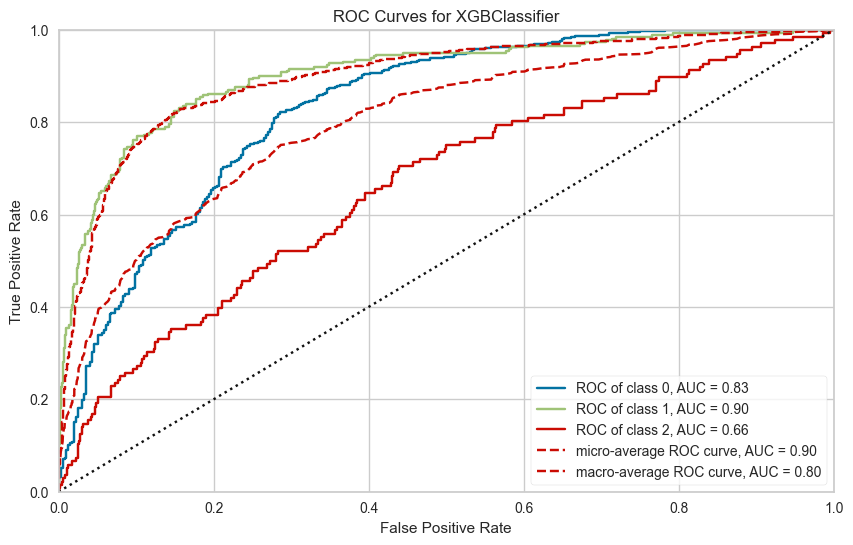

In [ ]:
from yellowbrick.classifier import ROCAUC

rf_model = XGBClassifier()
visualizer = ROCAUC(rf_model)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();  

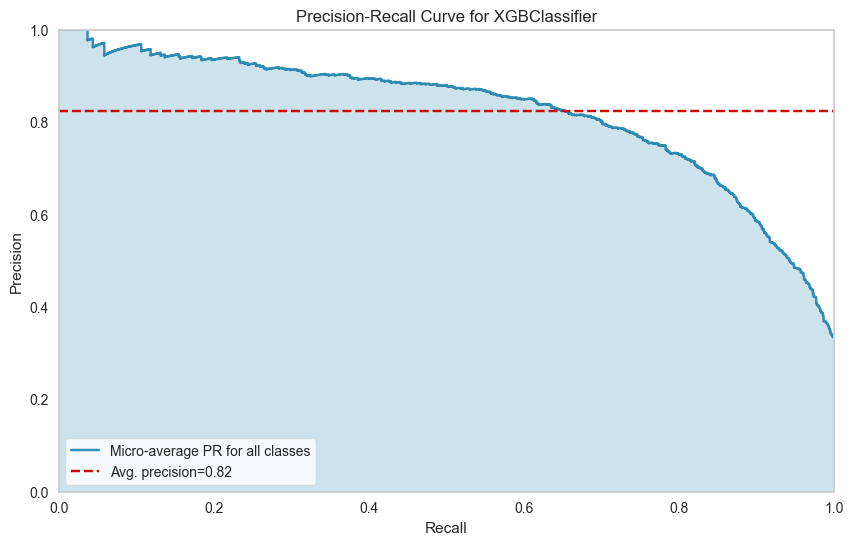

In [ ]:
from yellowbrick.classifier import PrecisionRecallCurve

rf_model = XGBClassifier()
visualizer = PrecisionRecallCurve(rf_model)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();  

# Compare The Models

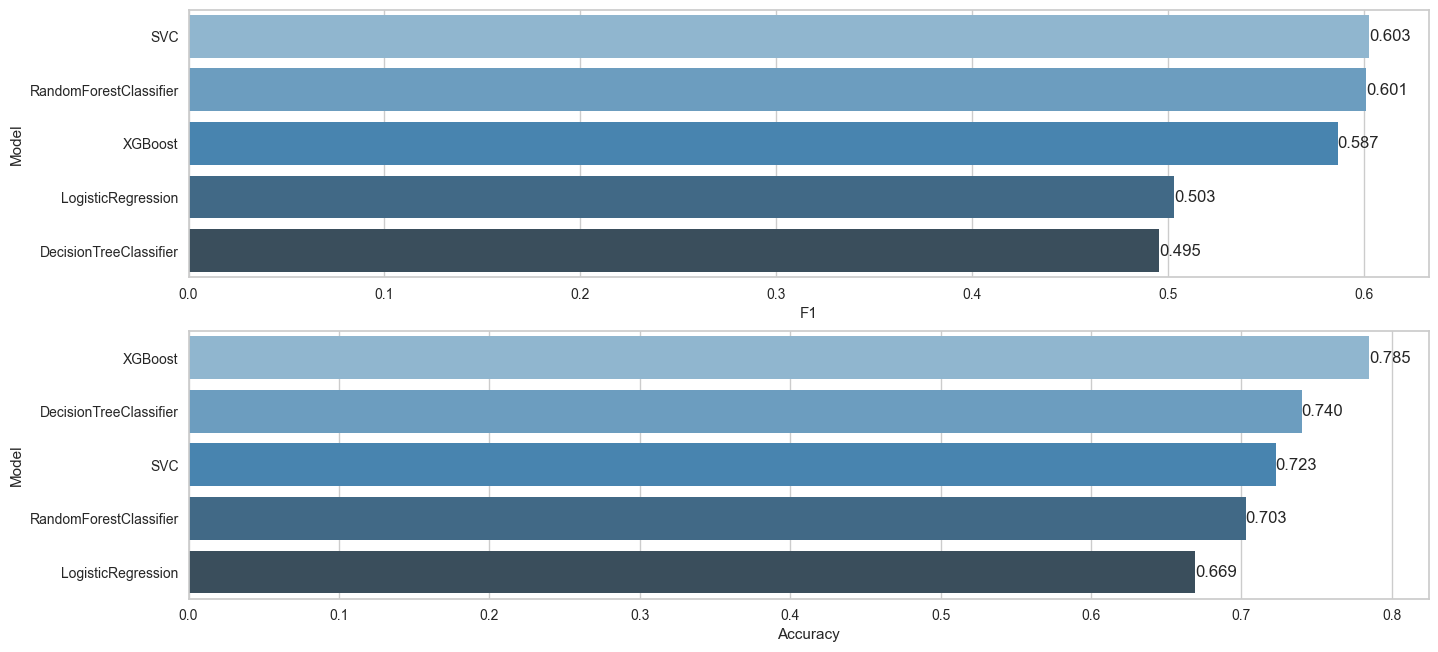

In [ ]:
compare = pd.DataFrame({"Model": ["LogisticRegression", "DecisionTreeClassifier", "SVC", "RandomForestClassifier", "XGBoost"],
                        "Accuracy": [log_accuracy_test, dt_accuracy_test, svm_accuracy_test, rf_accuracy_test, xgb_accuracy_test],
                        "F1": [log_f1_test, dt_f1_test, svm_f1_test, rf_f1_test, xgb_f1_test]})

def labels(ax):
    for p in ax.patches:
        width = p.get_width()                        # get bar length
        ax.text(width,                               # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2,      # get Y coordinate + X coordinate / 2
                '{:1.3f}'.format(width),             # set variable to display, 2 decimals
                ha = 'left',                         # horizontal alignment
                va = 'center')                       # vertical alignment
    
plt.figure(figsize=(16,16))

plt.subplot(411)
compare = compare.sort_values(by="F1", ascending=False)
ax=sns.barplot(x="F1", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(412)
compare = compare.sort_values(by="Accuracy", ascending=False)
ax=sns.barplot(x="Accuracy", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.show()

## Feature importances in XGBoost

In [ ]:
model = XGBClassifier(booster='gbtree',
 eta=0.1,
 colsample_bytree= 0.5,
 learning_rate= 0.1,
 max_depth= 3,
 n_estimators= 200,
 reg_alpha= 1,
 subsample= 0.5,
 random_state=101)

model.fit(X_train, y_train)

model.feature_importances_

feats = pd.DataFrame(index=X.columns, data=model.feature_importances_, columns=['xgb_importance'])
xgb_imp_feats = feats.sort_values("xgb_importance")
xgb_imp_feats

,xgb_importance
Age,0.025589
Heightin,0.027183
acromionradialelength,0.028765
cervicaleheight,0.030369
shoulderelbowlength,0.031825
acromialheight,0.031998
weightkg,0.032097
wristcircumference,0.032513
chestheight,0.033267
shoulderlength,0.033533


## SHAP with XGBOOST

In [ ]:
import shap

In [ ]:

explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)

Permutation explainer: 1155it [07:22,  2.59it/s]                          


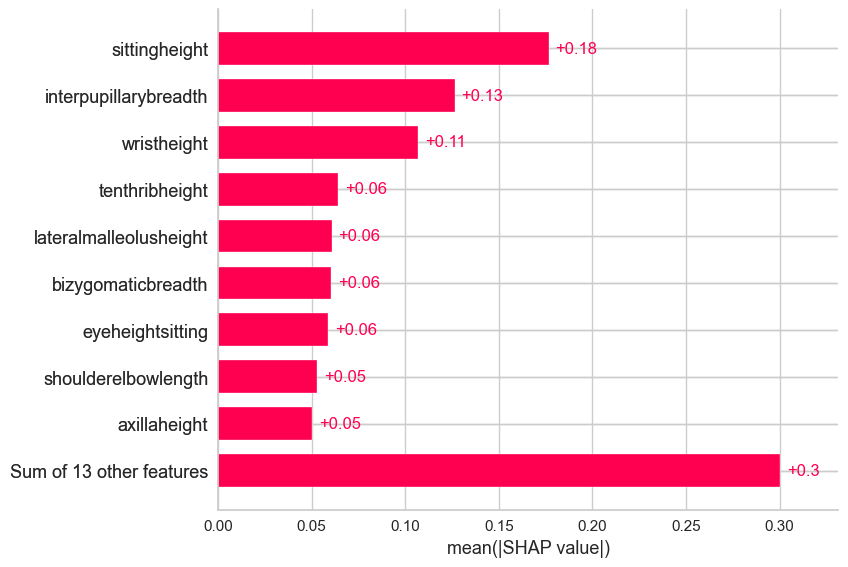

In [ ]:
shap.plots.bar(shap_values)

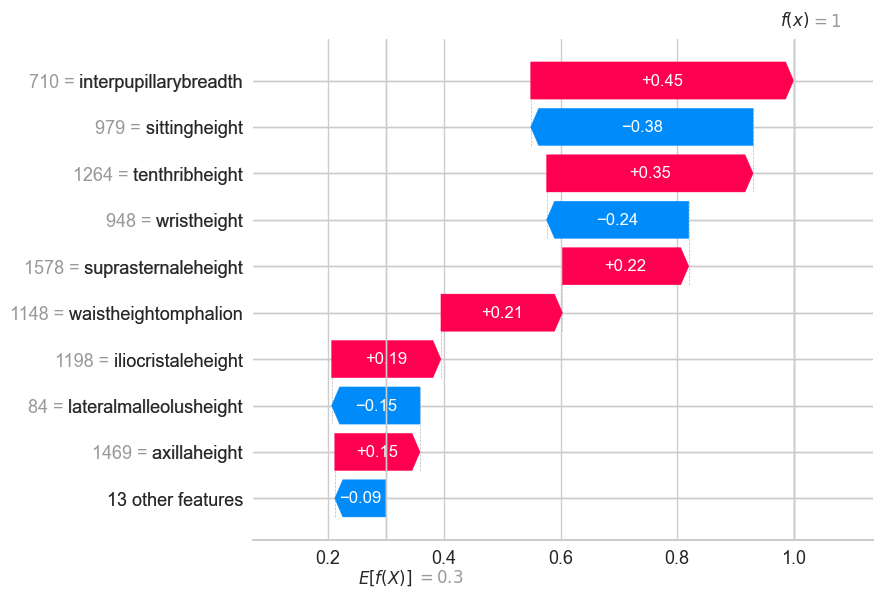

In [ ]:
shap.plots.waterfall(shap_values[0])

## SMOTE with DecisionTreeClassifier

In [ ]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
 n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# values to evaluate
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
 # define pipeline
 model = DecisionTreeClassifier()
 over = SMOTE(sampling_strategy=0.1, k_neighbors=k)
 under = RandomUnderSampler(sampling_strategy=0.5)
 steps = [('over', over), ('under', under), ('model', model)]
 pipeline = Pipeline(steps=steps)
 # evaluate pipeline
 cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
 score = mean(scores)
 print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=1, Mean ROC AUC: 0.828
> k=2, Mean ROC AUC: 0.822
> k=3, Mean ROC AUC: 0.824
> k=4, Mean ROC AUC: 0.837
> k=5, Mean ROC AUC: 0.840
> k=6, Mean ROC AUC: 0.845
> k=7, Mean ROC AUC: 0.850


## SMOTE with XGBoost

In [ ]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
 n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# define model
model = model
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=101)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.766


<p style="text-align: center;"><img src="https://lms.techproeducation.com/pluginfile.php/1/theme_edumy/headerlogo2/1663129929/logo.png" class="img-fluid" alt="CLRSWY"></p>